## TUTORIAL 01 - Thermal block problem
**_Keywords: certified reduced basis method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional domain $\Omega$.

<img src="data/thermal_block.png" />

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv k_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster evaluation (yet, provably accurate) of the output of interest we propose to use a certified reduced basis approximation for the problem.

### 2. Parametrized formulation

Let $u(\bm{\mu})$ be the temperature in the domain $\Omega$.

The strong formulation of the parametrized problem is given by:
for a given parameter $\bm{\mu}\in\mathbb{P}$, find $u(\bm{\mu})$ such that

$$
\begin{cases}
	- \text{div} (\kappa(\mu_0)\nabla u(\boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
	u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}.
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads:
for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

The (compliant) output of interest $s(\boldsymbol{\mu})$ given by
$$s(\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
from dolfin import *
from rbnics import *

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class ThermalBlock(EllipticCoerciveCompliantProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ThermalBlock(EllipticCoerciveCompliantProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveCompliantProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "ThermalBlock"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ThermalBlock class

In [5]:
problem = ThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = ReducedBasis(problem)
reduction_method.set_Nmax(4)
reduction_method.set_tolerance(1e-5)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

### 4.6. Perform an online solve

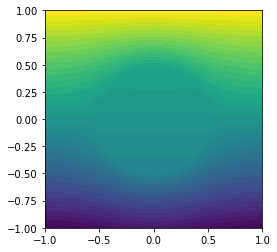

In [8]:
online_mu = (8.0, -1.0)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
plot(reduced_solution, reduced_problem=reduced_problem)

### 4.7. Perform an error analysis

In [9]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

=                    ThermalBlock RB error analysis begins                     =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

### 4.8. Perform a speedup analysis

In [10]:
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()

=                   ThermalBlock RB speedup analysis begins                    =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

## 5. Assignments
1. Assume now also the conductivity on $\Omega_2$ to be paramerized, i.e.
$$
\kappa(\mu_0, \mu_2) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	\mu_2 & \text{in } \Omega_2,\\
\end{cases}
$$
for
$$
\boldsymbol{\mu} = (\mu_0, \mu_1, \mu_2) \in \mathbb{P}=[0.1,10]\times[-1,1] \times [0.1,10].
$$
Create a copy of this notebook and update the code accordingly. _Suggestion: for every new notebook copy change the value returned by the name() method of the ThermalBlock class to avoid conflicts between this notebook and your copy_.

2. Create another copy of this notebook, and change the model reduction technique from certified reduced basis to POD-Galerkin. Compare the results of the error analysis and speedup analysis for the two reduction techniques.

3. [*] Why is the $H^1$ seminorm used on $\mathbb{V}$? What would you need to change by using the $H^1$ norm instead?